Google Colab上執行
SourceCode@Google Colab: https://colab.research.google.com/drive/1WHnj9rH6d2b_snSY31vNifJdmRAeGGzH  
參考:https://github.com/keras-team/keras-applications/tree/master/keras_applications

In [10]:
# _*_ coding: utf-8 _*_
# _*_ coding: cp950 _*_

# author: Chi-Hsu Chen (css920@gmail.com)

import numpy as np
import cv2
import time
from google.colab.patches import cv2_imshow

from keras import utils
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model,Sequential,Input
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Convolution2D
from keras.layers import Input,GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers import BatchNormalization,Activation,Dropout,Reshape
from keras import layers
from keras import backend as K
from keras.layers import Lambda
from keras.layers import Concatenate

from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder

import keras

# pip install captcha

In [1]:
pip install captcha

     |████████████████████████████████| 102kB 2.8MB/s 


# 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, 'VDRM')

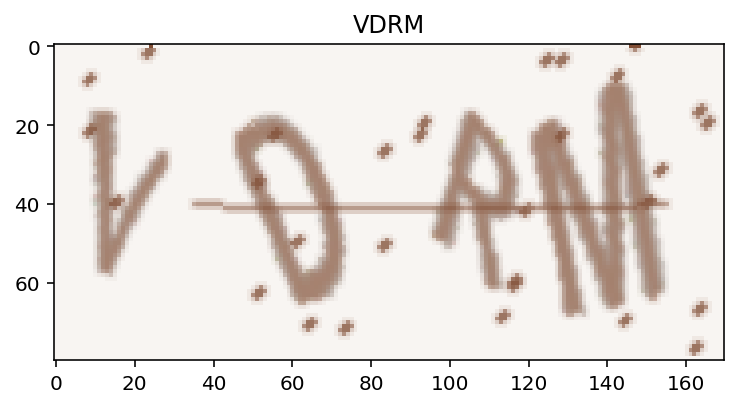

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
##驗證碼包含0-10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

##設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

##設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

##我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

# 建構CNN網路

In [12]:
##CTC Loss需要四個資訊，分別是
## Label
## 預測
## CNN OUTPUT寬度
## 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [13]:
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)

##記錄輸出CNN尺寸，loss部分需要這個資訊
##conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()

##從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)


##包裝用來預測的model
base_model = Model(input=input_tensor, output=x)


##設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [14]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 78, 168, 32)  896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 78, 168, 32)  128         conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 76, 166, 32)  9248        batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [15]:
##設計generator產生training data
## 產生包含要給loss的資訊
## X=輸入影像
## np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
## np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y,np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[ 5 14 30  0]]
CNN輸出寬度:  [13.]
字串長度(可浮動):  [4.]


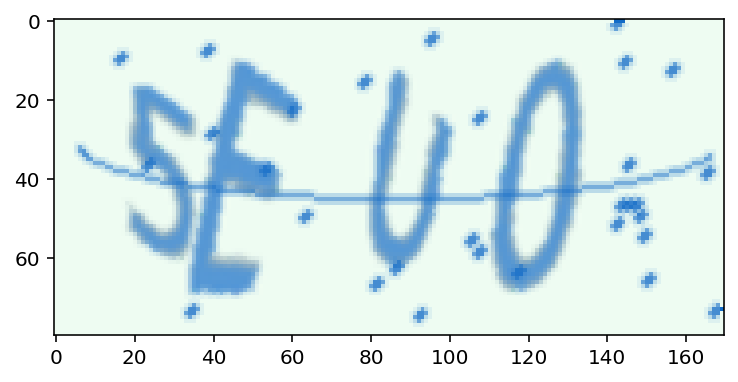

In [16]:
next_ge=gen(batch_size=1)
test_ge=next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

# 開始訓練

In [17]:
model.fit_generator(gen(32), steps_per_epoch=300, epochs=60)

Epoch 1/60
300/300 [==============================] - 71s 236ms/step - loss: 15.5240
Epoch 2/60
300/300 [==============================] - 64s 212ms/step - loss: 11.2851
Epoch 3/60
300/300 [==============================] - 63s 211ms/step - loss: 7.9496
Epoch 4/60
300/300 [==============================] - 64s 214ms/step - loss: 6.1260
Epoch 5/60
300/300 [==============================] - 63s 212ms/step - loss: 5.0040
Epoch 6/60
300/300 [==============================] - 64s 212ms/step - loss: 4.3504
Epoch 7/60
300/300 [==============================] - 64s 212ms/step - loss: 4.0451
Epoch 8/60
300/300 [==============================] - 64s 213ms/step - loss: 3.7422
Epoch 9/60
300/300 [==============================] - 64s 214ms/step - loss: 3.4909
Epoch 10/60
300/300 [==============================] - 64s 212ms/step - loss: 3.3002
Epoch 11/60
300/300 [==============================] - 63s 212ms/step - loss: 3.2335
Epoch 12/60
300/300 [==============================] - 63s 211ms/step - 

In [20]:
model.save('iter60.h5')

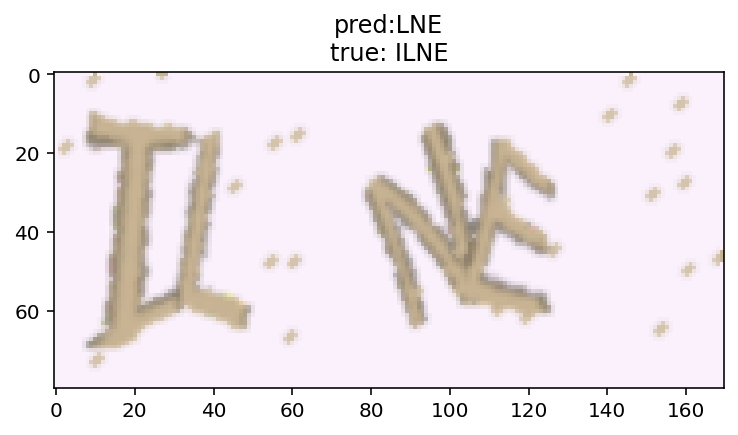

In [19]:
# 預測
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]